In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import glob
import scipy as sps
from scipy import stats
import matplotlib.gridspec as gridspec
from matplotlib.lines import Line2D

In [51]:
df_list = [] 
a = ''
for file in os.listdir('dados/c_selecao/'): 
    if (('.~lock' in file)==False):
        if ('casa' in file):
            df = pd.read_csv('Resultados_casa_611/C_sele/v_1/'+file).rename(columns = {'key_resp_11.rt':'A.rt', \
                                                                                'key_resp_12.rt' : 'B.rt', \
                                                                                'key_resp_13.rt':'C.rt', \
                                                                                'key_resp_15.keys': 'resposta', \
                                                                                'key_resp_15.rt':'quest.rt'}).iloc[12:-2, :]
            
            df_list.append(df) 
           
        else:
             df = pd.read_csv('dados/c_selecao/'+file).rename(columns = {'key_resp_11.rt':'A.rt', \
                                                                                'key_resp_12.rt' : 'B.rt', \
                                                                                'key_resp_13.rt':'C.rt', \
                                                                                'key_resp_15.keys': 'resposta', \
                                                                                'key_resp_15.rt':'quest.rt'}).iloc[4:-1, :]
          
             df_list.append(df) 
#final_df = df.append(df for df in df_list) 
#final_df.to_csv('final.csv', index=False) 

In [52]:
dfs_foco = pd.read_csv('preprocessed.csv').iloc[:, 1:]

In [53]:
condicoes = pd.read_excel('Condicoes.xlsx')
condicoes['frase'] = ['C_'+str(i) for i in range(1,145)]

<ipython-input-53-8b99ee40d3f9>:1: FutureWarning: Your version of xlrd is 1.2.0. In xlrd >= 2.0, only the xls format is supported. As a result, the openpyxl engine will be used if it is installed and the engine argument is not specified. Install openpyxl instead.
  condicoes = pd.read_excel('Condicoes.xlsx')


In [54]:
condicoes.iloc[:6, :]

,condicoes,frase
0,S_CE,C_1
1,S_EC,C_2
2,A_CE,C_3
3,A_EC,C_4
4,C,C_5
5,E,C_6


In [55]:
dfs = pd.concat([df[['participant', 'soundsA', 'A.rt', 'B.rt', 'C.rt', 'resposta', 'quest.rt']] for df in df_list])

In [56]:
dfs.shape

(2803, 7)

In [57]:
def files(soundsA):
    return soundsA[soundsA.index('/'):soundsA.index('A')]

In [58]:
audio_files = [soundsA[soundsA.index('/')+1:soundsA.index('A')] for soundsA in dfs.soundsA.values]

In [59]:
dfs['frase'] = audio_files

In [60]:
treino = []
for audio in audio_files:
    if ('C' in audio):
        treino.append('foco')
    else:
        treino.append('distratora')

In [61]:
dfs['foco'] = treino

In [62]:
dfs.head()

,participant,soundsA,A.rt,B.rt,C.rt,resposta,quest.rt,frase,foco
12,Gabriel_teste,c_selecao_v1_wav/C_17A.wav,3.561946,0.843855,0.923700,s,5.012681,C_17,foco
13,Gabriel_teste,c_selecao_v1_wav/S_3A.wav,0.174023,0.228532,0.227010,s,2.339995,S_3,distratora
14,Gabriel_teste,c_selecao_v1_wav/C_79A.wav,0.722390,1.142884,1.149738,n,3.402495,C_79,foco
15,Gabriel_teste,c_selecao_v1_wav/D_7A.wav,0.195423,0.781601,1.114688,n,2.308383,D_7,distratora
16,Gabriel_teste,c_selecao_v1_wav/D_17A.wav,0.451732,0.676307,0.669188,s,3.243371,D_17,distratora


In [63]:
len(dfs[dfs.foco=='foco'].soundsA.unique())

108

In [64]:
conds = []
for frase in dfs[dfs.foco=='foco'].frase:
    conds.append(condicoes[condicoes.frase==frase].condicoes.values[0])

In [65]:
for name, group in dfs_foco.groupby('participant'):
    group.to_csv('C_sele_23nov/'+name+'.csv')

In [66]:
dfs_foco[dfs_foco['quest.rt']==dfs_foco['quest.rt'].max()]

,participant,soundsA,A.rt,B.rt,C.rt,resposta,quest.rt,frase,foco,condicao
469,micreli_1611,c_selecao_v3_wav/C_29A.wav,2.074825,0.86595,0.449655,n,39.4777,C_29,foco,C


In [67]:
dfs_foco.head()

,participant,soundsA,A.rt,B.rt,C.rt,resposta,quest.rt,frase,foco,condicao
0,Gabriel_teste,c_selecao_v1_wav/C_17A.wav,3.561946,0.843855,0.923700,s,5.012681,C_17,foco,C
1,Gabriel_teste,c_selecao_v1_wav/C_79A.wav,0.722390,1.142884,1.149738,n,3.402495,C_79,foco,S_CE
2,Gabriel_teste,c_selecao_v1_wav/C_118A.wav,1.025974,0.457798,0.469199,n,0.828542,C_118,foco,A_EC
3,Gabriel_teste,c_selecao_v1_wav/C_59A.wav,0.558070,0.495569,0.438686,s,3.592213,C_59,foco,C
4,Gabriel_teste,c_selecao_v1_wav/C_107A.wav,1.059711,0.698479,0.568666,s,1.830431,C_107,foco,C


## Gram. Judgments

In [68]:
def barplot_annotate_brackets(num1, num2, data, center, height, yerr=None, dh=.02, barh=.01, fs=None, maxasterix=4):
    if type(data) is str:
        text = data
    else:
        # * is p < 0.05
        # ** is p < 0.005
        # *** is p < 0.0005
        # etc.
        text = ''
        p = .05
        if (np.round(data, 3) == 0.051):
            data = 0.05
        while data <= p:
            text += '*'
            p /= 10.

            if maxasterix and len(text) == maxasterix:
                break
        if (text=='****'):
            text = '***'
        if len(text) == 0:
            text ='n.s.'
    '''if (text!='n. s.'):
        if (len(text)==1):
            text='p ='+str(np.round(data, 3))+'\n'+text
        elif (len(text)==2):
            text='p ='+str(np.round(data, 3))+'\n'+text
        elif (len(text)==3):
            text='p < 0.0005'+str(np.round(data, 3))+text
        '''
    lx, ly = center[num1], height[num1]
    rx, ry = center[num2], height[num2]

    if yerr:
        ly += yerr[num1]
        ry += yerr[num2]

    ax_y0, ax_y1 = plt.gca().get_ylim()
    dh *= (ax_y1 - ax_y0)
    barh *= (ax_y1 - ax_y0)

    y = max(ly, ry) + dh

    barx = [lx, lx, rx, rx]
    bary = [y, y+barh, y+barh, y]
    mid = ((lx+rx)/2, y+barh)

    plt.plot(barx, bary, c='black')

    kwargs = dict(ha='center', va='bottom')
    if fs is not None:
        kwargs['fontsize'] = fs

    plt.text(*mid, text, **kwargs)

In [69]:
df_time = pd.DataFrame(np.array([dfs_foco['A.rt'].values, dfs_foco['B.rt'], dfs_foco['C.rt']]).flatten(), columns=['time'])

<AxesSubplot:>

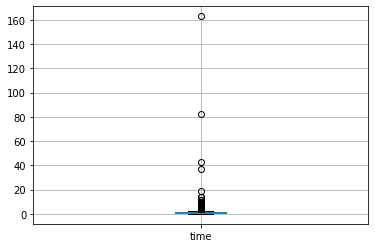

In [70]:
df_time.boxplot(column=['time'])

In [71]:
def disflu(condicao):
    if (condicao=='E' or condicao=='C'):
        return 0
    else:
        return 1

In [72]:
def trans_participante(df):
    dfs = []
    for name, group in df.groupby('participant'):
        dfx = group
        for trecho in (['A.rt', 'B.rt', 'C.rt', 'quest.rt']):
            mean = dfx[trecho].mean()
            std =  dfx[trecho].std()
            dfx.loc[dfx[trecho] > mean+std, trecho] = np.NaN
        dfs.append(dfx)
    return pd.concat(dfs)

In [73]:
df_sup = dfs_foco[['A.rt', 'B.rt', 'C.rt', 'quest.rt']]
#df_sup[df_sup>3.84] = np.NaN
df_sup['frase'] = dfs_foco.frase
df_sup['resposta'] = dfs_foco.resposta
df_sup['condicao'] = dfs_foco.condicao
df_sup['participant'] = dfs_foco.participant
df = df_sup
df['disfluency'] = df.condicao.apply(disflu)

<ipython-input-73-846c00aa2acf>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sup['frase'] = dfs_foco.frase
<ipython-input-73-846c00aa2acf>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sup['resposta'] = dfs_foco.resposta
<ipython-input-73-846c00aa2acf>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/

In [74]:
disf = trans_participante(df[df.disfluency==1])

In [75]:
ndisf = trans_participante(df[df.disfluency==0])

In [76]:
df_trans = pd.concat([disf, ndisf])

[23.52941176 10.59259259 36.24161074]
[88.74172185 43.92592593 78.6163522 ]


<ipython-input-54-529df0037bf8>:47: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig2.tight_layout(pad=2)


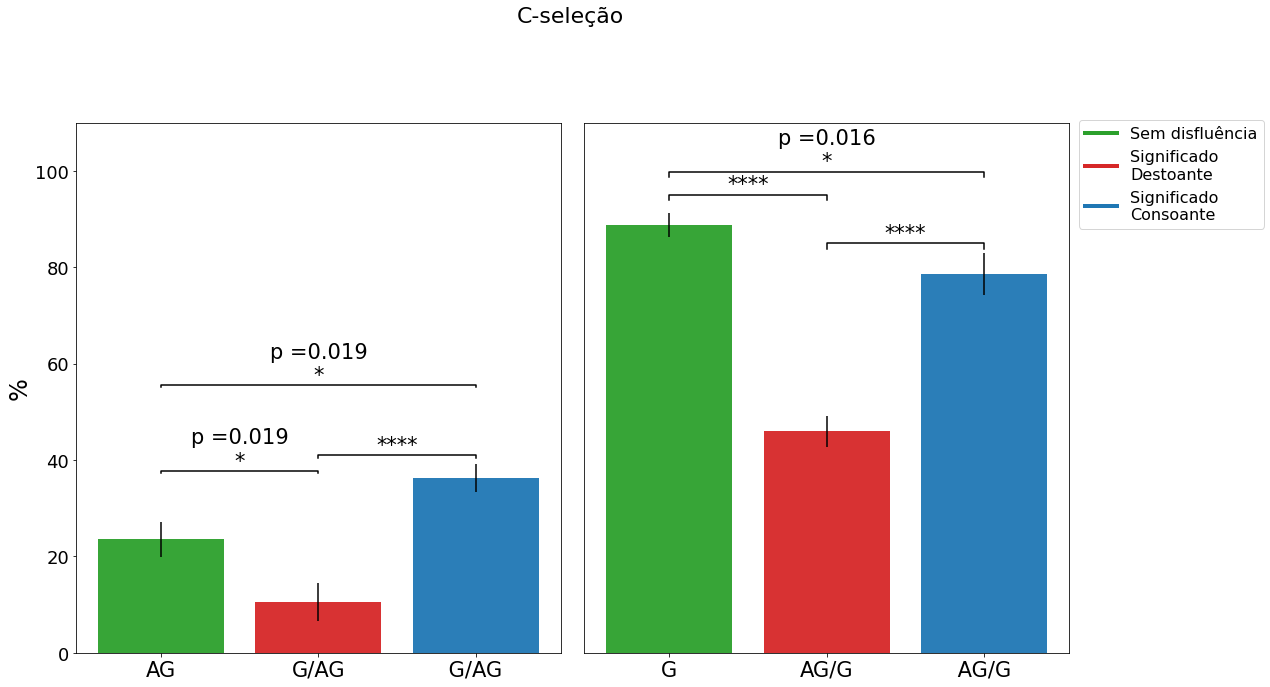

In [54]:
fig2 = plt.figure(constrained_layout=True, figsize=(18,9))
spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)

l_c = df[df.condicao=='C']['resposta'].replace(['s', 'n'], [1, 0]).values
l_e = df[df.condicao=='E']['resposta'].replace(['s', 'n'], [1, 0]).values
l_sce = df[df.condicao=='S_CE']['resposta'].replace(['s', 'n'], [1, 0]).values
l_ace = df[df.condicao=='A_CE']['resposta'].replace(['s', 'n'], [1, 0]).values
l_sec = df[df.condicao=='S_EC']['resposta'].replace(['s', 'n'], [1, 0]).values
l_aec = df[df.condicao=='A_EC']['resposta'].replace(['s', 'n'], [1, 0]).values

f=21
f2_ax2 = fig2.add_subplot(spec2[0, 0])
heights = np.array([l_e.mean()*100, l_ace.mean()*100-2, l_sce.mean()*100])
print(heights)
yerr = [sps.stats.sem(l_e*100), sps.stats.sem(l_sce*100), sps.stats.sem(l_ace*100)]
plt.bar([0,1,2], heights ,  color=['tab:green', 'tab:red', 'tab:blue'], yerr=yerr, lw=10, alpha=.95)
plt.xticks([0,1,2], labels=['AG', 'G/AG', ' G/AG '], fontsize=21)

barplot_annotate_brackets(0, 1, stats.ttest_ind(l_ace, l_e)[1], np.array([0,1,2]), heights+13, fs=f)
barplot_annotate_brackets(0, 2, stats.ttest_ind(l_sce, l_e)[1], np.array([0,1,2]), heights+18, fs=f)
barplot_annotate_brackets(1, 2, stats.ttest_ind(l_sce, l_ace)[1], np.array([0,1,2]), heights+3, fs=f)

plt.ylim(0,110)
plt.yticks(np.arange(0,120,20), fontsize=18)
plt.ylabel('%', fontsize=24)


f2_ax2 = fig2.add_subplot(spec2[0, 1])
plt.ylim(0,110)
plt.yticks([])
yerr = [sps.stats.sem(l_c*100), sps.stats.sem(l_sec*100), sps.stats.sem(l_aec*100)]
heights = np.array([l_c.mean()*100, l_aec.mean()*100-2, l_sec.mean()*100])
print(heights)
plt.bar([0,1,2], [l_c.mean()*100, l_aec.mean()*100, l_sec.mean()*100],yerr=yerr,  color=['tab:green', 'tab:red', 'tab:blue'],  lw=10, alpha=.95)
plt.xticks([0,1,2], labels=['G', 'AG/G', ' AG/G '], fontsize=21)
barplot_annotate_brackets(0, 1, stats.ttest_ind(l_aec, l_c)[1], np.array([0,1,2]), heights+3, fs=f)
barplot_annotate_brackets(0, 2, stats.ttest_ind(l_sec, l_c)[1], np.array([0,1,2]), heights+7.8, fs=f)
barplot_annotate_brackets(1, 2, stats.ttest_ind(l_sce, l_ace)[1], np.array([0,1,2]), heights+3, fs=f)

custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(custom_lines, ['Sem disfluência', 'Significado\nDestoante', 'Significado\nConsoante'], loc=(1.02,.8), fontsize=16)


plt.suptitle('C-seleção', x=.45, y=1.07, fontsize=22)
fig2.tight_layout(pad=2)
#plt.savefig('14mar/C_sele_SEMRUINS.png', dpi=150, bbox_inches='tight')

Ttest_indResult(statistic=-2.35427794099849, pvalue=0.01927795225725536)
Ttest_indResult(statistic=2.3496110394720184, pvalue=0.019480282395264868)
Ttest_indResult(statistic=4.760630132159788, pvalue=3.088857558784005e-06)
Ttest_indResult(statistic=-8.737027552195595, pvalue=2.11440406588129e-16)
Ttest_indResult(statistic=-2.418371385460253, pvalue=0.016169913912263665)
Ttest_indResult(statistic=4.760630132159788, pvalue=3.088857558784005e-06)


<ipython-input-77-961a184f3821>:55: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  fig2.tight_layout(pad=2)


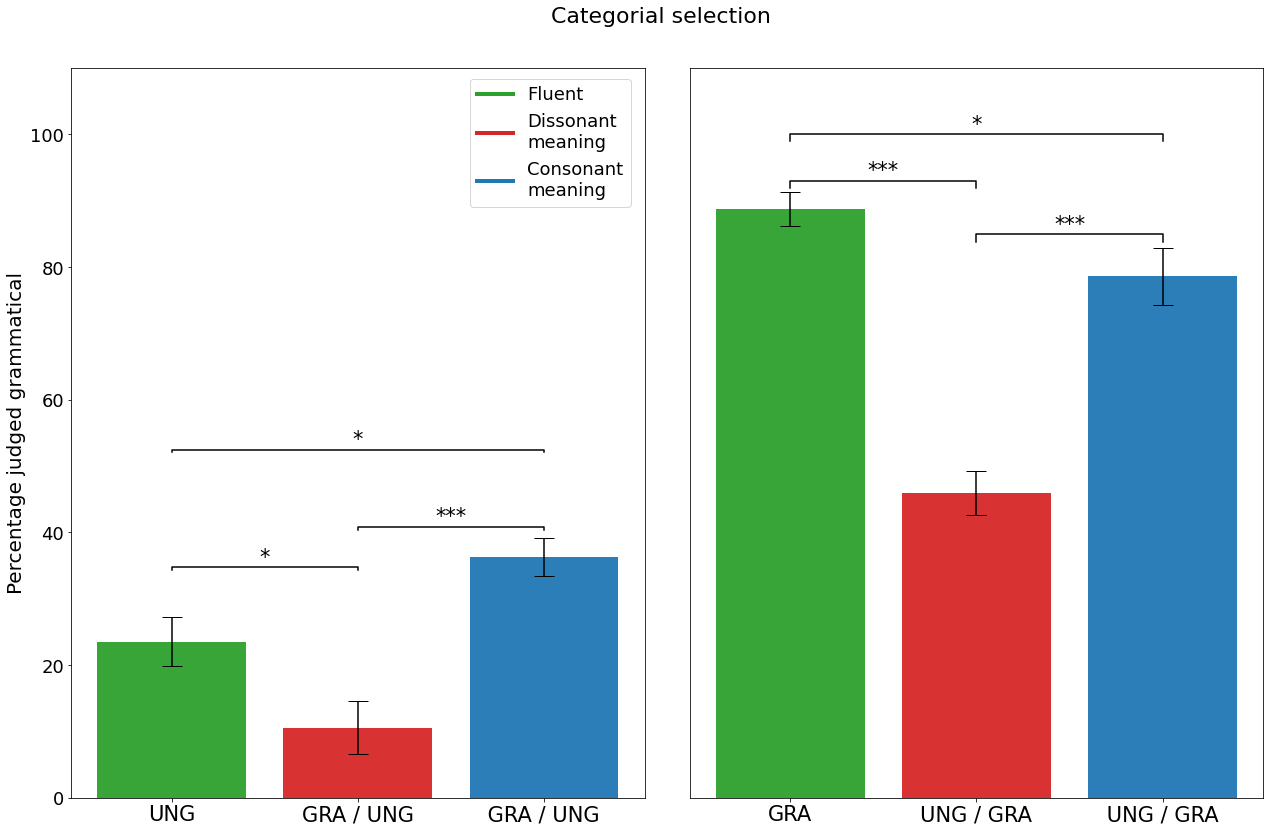

In [77]:
fig2 = plt.figure(constrained_layout=True, figsize=(18,12))
spec2 = gridspec.GridSpec(ncols=2, nrows=1, figure=fig2)

l_c = df[df.condicao=='C']['resposta'].replace(['s', 'n'], [1, 0]).values
l_e = df[df.condicao=='E']['resposta'].replace(['s', 'n'], [1, 0]).values
l_sce = df[df.condicao=='S_CE']['resposta'].replace(['s', 'n'], [1, 0]).values
l_ace = df[df.condicao=='A_CE']['resposta'].replace(['s', 'n'], [1, 0]).values
l_sec = df[df.condicao=='S_EC']['resposta'].replace(['s', 'n'], [1, 0]).values
l_aec = df[df.condicao=='A_EC']['resposta'].replace(['s', 'n'], [1, 0]).values

f=21
f2_ax2 = fig2.add_subplot(spec2[0, 0])
heights = np.array([l_e.mean()*100, l_ace.mean()*100-2, l_sce.mean()*100])
yerr = [sps.stats.sem(l_e*100), sps.stats.sem(l_sce*100), sps.stats.sem(l_ace*100)]
plt.bar([0,1,2], heights ,  color=['tab:green', 'tab:red', 'tab:blue'], yerr=yerr, capsize=10, lw=10, alpha=.95)
plt.xticks([0,1,2], labels=['UNG', 'GRA / UNG', ' GRA / UNG '], fontsize=21)

barplot_annotate_brackets(0, 1, stats.ttest_ind(l_ace, l_e)[1], np.array([0,1,2]), heights+10, fs=f)
print(stats.ttest_ind(l_ace, l_e))
barplot_annotate_brackets(0, 2, stats.ttest_ind(l_sce, l_e)[1], np.array([0,1,2]), heights+15, fs=f)
print(stats.ttest_ind(l_sce, l_e))
barplot_annotate_brackets(1, 2, stats.ttest_ind(l_sce, l_ace)[1], np.array([0,1,2]), heights+3, fs=f)
print(stats.ttest_ind(l_sce, l_ace))


plt.ylim(0,110)
plt.yticks(np.arange(0,120,20), fontsize=18)
plt.ylabel('Percentage judged grammatical', fontsize=20)
custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(custom_lines, ['Fluent', 'Dissonant\nmeaning', 'Consonant\nmeaning'], loc=(.695,.81), fontsize=18)

f2_ax2 = fig2.add_subplot(spec2[0, 1])
plt.ylim(0,110)
plt.yticks([])
yerr = [sps.stats.sem(l_c*100), sps.stats.sem(l_sec*100), sps.stats.sem(l_aec*100)]
heights = np.array([l_c.mean()*100, l_aec.mean()*100-2, l_sec.mean()*100])
plt.bar([0,1,2], [l_c.mean()*100, l_aec.mean()*100, l_sec.mean()*100],yerr=yerr, capsize=10,color=['tab:green', 'tab:red', 'tab:blue'],  lw=10, alpha=.95)
plt.xticks([0,1,2], labels=['GRA', 'UNG / GRA', ' UNG / GRA '], fontsize=21)
barplot_annotate_brackets(0, 1, stats.ttest_ind(l_aec, l_c)[1], np.array([0,1,2]), heights+1, fs=f)
print(stats.ttest_ind(l_aec, l_c))
barplot_annotate_brackets(0, 2, stats.ttest_ind(l_sec, l_c)[1], np.array([0,1,2]), heights+8, fs=f)
print(stats.ttest_ind(l_sec, l_c))
barplot_annotate_brackets(1, 2, stats.ttest_ind(l_sce, l_ace)[1], np.array([0,1,2]), heights+3, fs=f)
print(stats.ttest_ind(l_sce, l_ace))

'''custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(custom_lines, ['Fluent', 'Dissonant\nmeaning', 'Consonant\nmeaning'], loc=(1.02,.76), fontsize=18)'''


plt.suptitle('Categorial selection\n', x=.52, y=.97, fontsize=22)
fig2.tight_layout(pad=2)
#plt.savefig('14mar/C_selecao_GRA_UNG.png', dpi=300, facecolor = 'white', bbox_inches='tight')

## Tempos

In [42]:
def tempo_rt(trecho,mark, savefig, ylim):
    df = df_trans
    yerr = []
    conds = [*df.groupby('condicao').groups.keys()]
    for name, group in df.groupby('condicao'):
        yerr.append(sps.stats.sem(group[trecho+'.rt'].fillna(0)))
    fig, ax = plt.subplots(figsize=(10,8))
    plt.bar(df.groupby('condicao').groups.keys(), df.groupby('condicao')[trecho+'.rt'].mean().values, \
            color = ['tab:red', 'tab:red', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue'], \
           yerr = yerr, align='center', capsize=6)
    
    plt.title('Trecho '+trecho)
    plt.xticks(np.arange(6), labels=['CE', 'EC', 'C', 'E', 'CE', 'EC'])
    plt.ylabel('s')
    if (ylim==0):
        plt.ylim(0,1.2)
    else:
        plt.ylim(0,ylim)
    custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                    Line2D([0], [0], color='tab:red', lw=4),
                    Line2D([0], [0], color='tab:blue', lw=4)]
    for  i in range(len(mark)):
        a1 = df.groupby('condicao').get_group(conds[mark[i][0]])[trecho+'.rt'].dropna(0)
        a2 = df.groupby('condicao').get_group(conds[mark[i][1]])[trecho+'.rt'].dropna(0)
        barplot_annotate_brackets(mark[i][0], mark[i][1], stats.ttest_ind(a1, a2)[1], np.arange(len(conds)), df.groupby('condicao')[trecho+'.rt'].mean().values+.07)
        print(stats.ttest_ind(a1, a2)[1])
    plt.legend(custom_lines, ['Sem disfluência', 'Verbos de significado\ndestoante', 'Verbos de significado\nconsoante'], loc=(1.02,.84))
    if (savefig):
        plt.savefig('Tempos/'+trecho+'.png', bbox_inches='tight')

In [262]:
conds = [*df.groupby('condicao').groups.keys()]

In [263]:
mark = [[0,1]]


In [264]:
a1 = df[df.condicao=='S_CE']['A.rt'].dropna()
a2 = df[df.condicao=='S_EC']['A.rt'].dropna()

In [116]:
a = [group['A.rt'].fillna(0).values.tolist() for name, group in df.groupby('condicao')]
np.round(stats.f_oneway(a[0], a[1], a[2], a[3], a[4], a[5])[0], 2)

0.42

0.2175544377408971
0.3237186171527787
0.3717732803144712


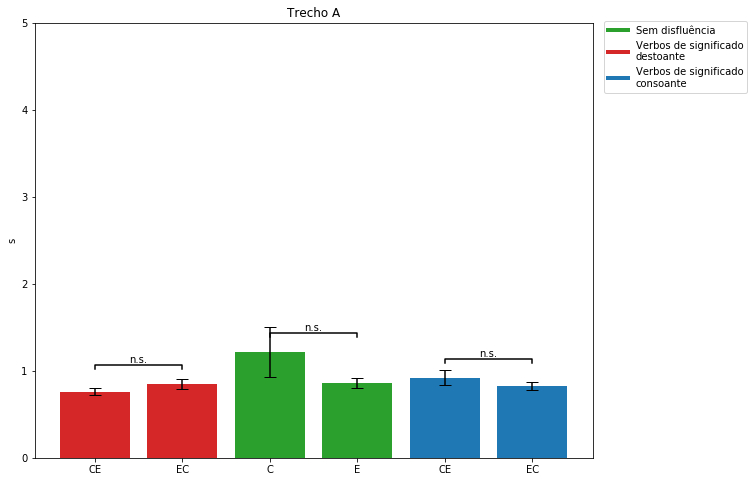

In [43]:
tempo_rt('A',[[0,1],[2, 3], [4,5]], False, 5)

In [44]:
a1 = df[df.condicao=='S_CE']['B.rt'].dropna(0)
a2 = df[df.condicao=='S_EC']['B.rt'].dropna(0)
stats.ttest_ind(a1, a2)[1].round(3)

0.222

0.6003955320279748
0.2832406950707618
0.14909197192780094


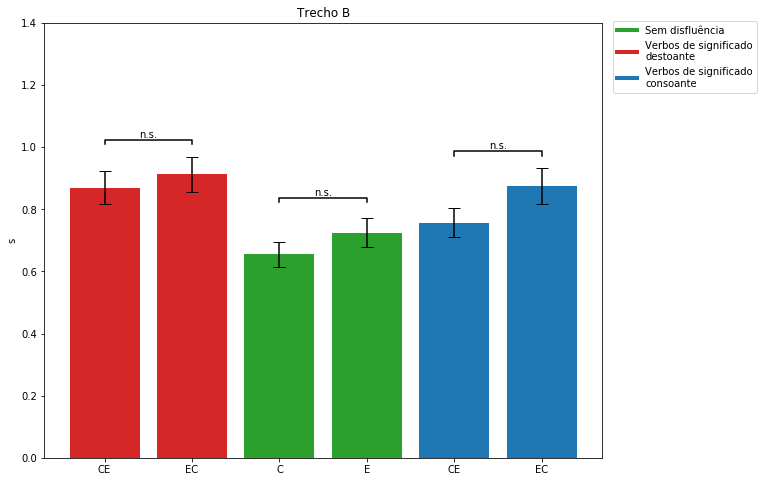

In [45]:
tempo_rt('B', [[0,1],[2,3], [4,5]], False, 1.4)

In [46]:
a1 = df[df.condicao=='S_CE']['C.rt'].dropna(0)
a2 = df[df.condicao=='S_EC']['C.rt'].dropna(0)

In [47]:
np.round(stats.ttest_ind(a1, a2)[1], 3)

0.025

0.08622291226036524
0.10309188280513802
0.07225891351257337


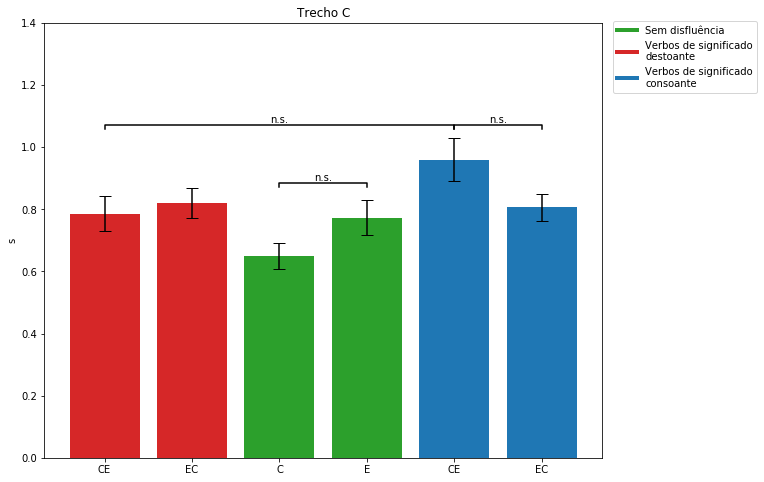

In [49]:
tempo_rt('C',[[0,4],[2,3],[4, 5]], False, 1.4)

0.29430960839848647
0.4098159044156151
0.32930169493714934


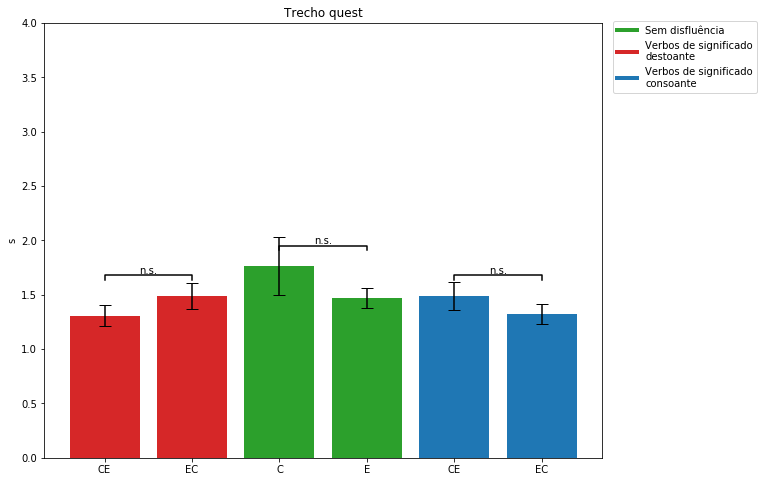

In [50]:
tempo_rt('quest',[[0,1], [2,3], [4,5]], False, 4)

In [73]:
yerr = []
for name, group in df.groupby('condicao'):
    yerr.append(sps.stats.sem(group['A.rt'].fillna(0)))

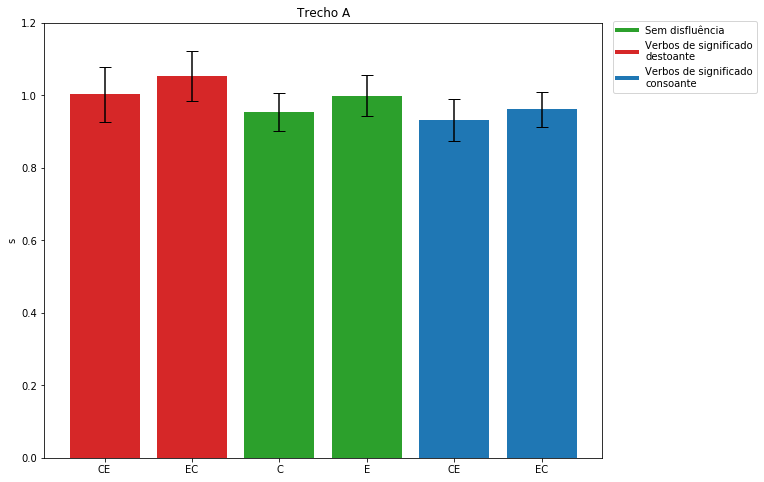

In [74]:
fig, ax = plt.subplots(figsize=(10,8))
plt.bar(df.groupby('condicao').groups.keys(), df.groupby('condicao')['A.rt'].mean().values, \
        color = ['tab:red', 'tab:red', 'tab:green', 'tab:green', 'tab:blue', 'tab:blue'], \
       yerr = yerr, align='center', capsize=6)
#ax.errorbar(df.groupby('condicao').groups.keys(), df.groupby('condicao')['A.rt'].mean().values, yerr=yerr, color='black')
plt.title('Trecho A')
plt.xticks(np.arange(6), labels=['CE', 'EC', 'C', 'E', 'CE', 'EC'])
plt.ylabel('s')
plt.ylim(0,1.2)
custom_lines = [Line2D([0], [0], color='tab:green', lw=4),
                Line2D([0], [0], color='tab:red', lw=4),
                Line2D([0], [0], color='tab:blue', lw=4)]
plt.legend(custom_lines, ['Sem disfluência', 'Verbos de significado\ndestoante', 'Verbos de significado\nconsoante'], loc=(1.02,.84))
plt.savefig('Tempos/A.png', bbox_inches='tight')

In [75]:
a = [group['A.rt'].fillna(0).values.tolist() for name, group in df.groupby('condicao')]

In [269]:
stats.f_oneway(a[0], a[1], a[2], a[3], a[4], a[5])

F_onewayResult(statistic=1.9393392681263741, pvalue=0.08512024671409663)

Text(0.5, 1.0, 'B')

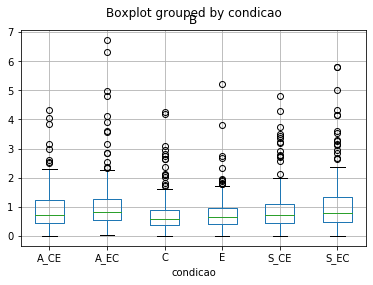

In [545]:
df.boxplot(column=['B.rt'],by='condicao')
plt.title('B')

Text(0.5, 1.0, 'Online\n\nB')

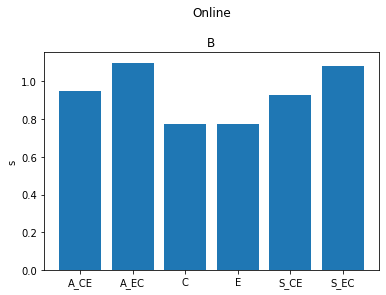

In [546]:
plt.bar(df.groupby('condicao').groups.keys(), df.groupby('condicao')['B.rt'].mean().values)
plt.ylabel('s')
plt.title('Online\n\nB')
#plt.savefig('Rt.B.Online.png', bbox_inches='tight')

In [ ]:
stats.ttest_ind(l_aec, l_c)[1]

<BarContainer object of 4 artists>

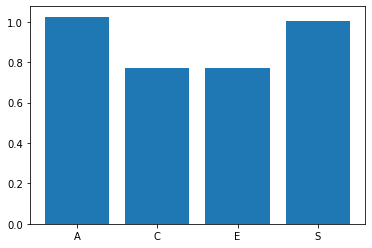

In [548]:
df_y = df.copy()
df_y.condicao = df_y.condicao.replace(['S_EC', 'S_CE', 'A_CE', 'A_EC'], ['S', 'S', 'A', 'A'])
plt.bar(df_y.groupby('condicao').groups.keys(), df_y.groupby('condicao')['B.rt'].mean().values)
#plt.savefig('Rt.B.Grouped_Online.png', bbox_inches='tight')

Text(0.5, 1.0, 'C')

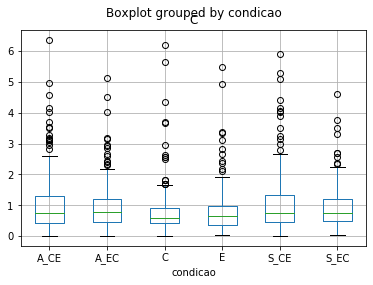

In [549]:
df.boxplot(column=['C.rt'],by='condicao')
plt.title('C')

Text(0.5, 1.0, 'Online\n\nC')

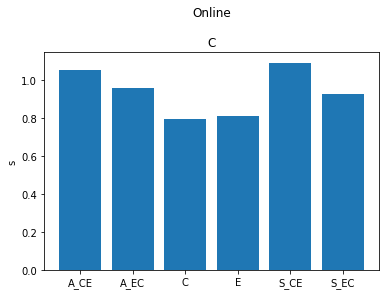

In [550]:
plt.bar(df.groupby('condicao').groups.keys(), df.groupby('condicao')['C.rt'].mean().values)
plt.title('C')
plt.ylabel('s')
plt.title('Online\n\nC')
#plt.savefig('Rt.C.Online.png', bbox_inches='tight')

<BarContainer object of 4 artists>

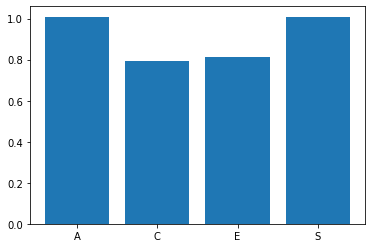

In [551]:
plt.bar(df_y.groupby('condicao').groups.keys(), df_y.groupby('condicao')['C.rt'].mean().values)
#plt.savefig('Rt.C.Grouped_Online.png', bbox_inches='tight')

## Tempo - Resposta

Text(0.5, 0.98, '')

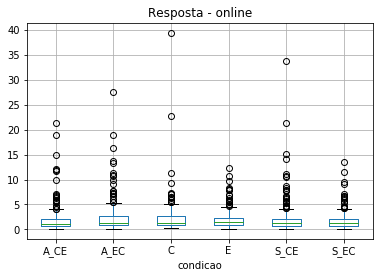

In [487]:
df.boxplot(column=['quest.rt'],by='condicao')
plt.title('Resposta - online')
plt.suptitle('')
#plt.savefig('Resposta_boxplot_casa.png', bbox_inches='tight')